## Heart Disease Diagnosis

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
df = pd.read_csv('../heartdisease_data.csv',sep= ',')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The data contains 13 features:<br/>
0) age: Age (years) --> discrete <br/>
1) sex: Sex (1: male, 0: female) --> binary <br/>
2) cp: Chest pain type (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic) --> categorical <br/>
3) trestbps: Resting blood pressure (mm Hg on admission to the hospital) --> continuous <br/>
4) chol: Cholesterol measurement (mg/dl) --> continuous <br/>
5) fbs: Fasting blood sugar (0: <120 mg/dl, 1: > 120 mg/dl) --> binary <br/>
6) restecg: Resting electrocardiographic measurement (0: normal, 1: having ST-T wave abnormality, 2: showing probable or definite left ventricular hypertrophy by Estes' criteria) --> categorical <br/>
7) thalach: Maximum heart rate achieved --> continuous<br/>
8) exang: Exercise induced angina (1: yes; 0: no) --> binary <br/>
9) oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot) --> continuous<br/>
10) slope: The slope of the peak exercise ST segment (1: upsloping, 2: flat, 3: downsloping) --> categorical<br/>
11) ca: The number of major vessels (0-4) --> categorical <br/>
12) thal: Thalassemia (a type of blood disorder)  (1: normal; 2: fixed defect; 3: reversable defect) --> categorical <br/>

and 1 target: Heart disease (0: no, 1: yes) <br/>

In [4]:
# select features and target:
df = np.array(df).astype(float)

# features:
X = df[:,:-1]
l,n = X.shape
print(l,n)

# target:
y = df[:,-1]
# convert 1,0 to 1,-1:
y = 2*y - 1

303 13


### Convert categorical variables to one hot

In [5]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')

# sex = X[:,1] = 0,1 --> 2
#x1 = onehot_encoder.fit_transform(X[:,1].reshape(-1,1))
x1 = 2*X[:,1] - 1   # 0,1 --> -1, 1

# cp = X[:,2] = 1,2,3,4 --> 4
x2 = onehot_encoder.fit_transform(X[:,2].reshape(-1,1))

# fbs = X[:,5] = 0,1 --> 2
#x5 = onehot_encoder.fit_transform(X[:,5].reshape(-1,1)) 
x5 = 2*X[:,5] - 1  # 0,1 --> -1, 1

# restecg = X[:,6] = 0,1,2 --> 3
x6 = onehot_encoder.fit_transform(X[:,6].reshape(-1,1))

#exang: = X[:,8] = 0,1 --> 2
#x8 = onehot_encoder.fit_transform(X[:,8].reshape(-1,1))
x8 = X[:,8]  # 0,1 --> -1, 1

# X[:,10] = 0,1,2 --> 3
x10 = onehot_encoder.fit_transform(X[:,10].reshape(-1,1))

# X[:,11] = 0,1,2,3,4 --> 5
x11 = onehot_encoder.fit_transform(X[:,11].reshape(-1,1)) 

# X[:,12] = 0,1,2,3 --> 4
x12= onehot_encoder.fit_transform(X[:,12].reshape(-1,1)) 

Xnew = np.hstack([X[:,0][:,np.newaxis],x1[:,np.newaxis]])
Xnew = np.hstack([Xnew,x2])
Xnew = np.hstack([Xnew,X[:,3:5]])
Xnew = np.hstack([Xnew,x5[:,np.newaxis]])
Xnew = np.hstack([Xnew,x6])
Xnew = np.hstack([Xnew,X[:,7][:,np.newaxis]])
Xnew = np.hstack([Xnew,x8[:,np.newaxis]])
Xnew = np.hstack([Xnew,X[:,9][:,np.newaxis]])
Xnew = np.hstack([Xnew,x10])
Xnew = np.hstack([Xnew,x11])
Xnew = np.hstack([Xnew,x12])

In [6]:
X = Xnew
X.shape

(303, 27)

In [7]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

### Prediction

In [8]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=20,regu=0.2)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [9]:
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)
        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [10]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','decision_tree','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.83852459 0.77459016 0.83360656 0.73147541 0.84803279]
0.6 [0.83606557 0.74098361 0.82754098 0.73655738 0.84180328]
0.4 [0.83147541 0.73114754 0.81803279 0.74131148 0.83606557]
0.2 [0.83606557 0.7047541  0.82131148 0.73393443 0.83721311]


In [11]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,decision_tree,expectation_reflection
0,0.8,0.838525,0.774590,0.833607,0.731475,0.848033
1,0.6,0.836066,0.740984,0.827541,0.736557,0.841803
2,0.4,0.831475,0.731148,0.818033,0.741311,0.836066
3,0.2,0.836066,0.704754,0.821311,0.733934,0.837213


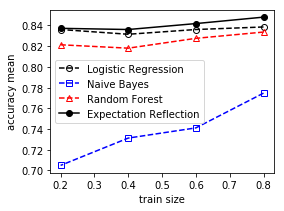

In [12]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,4],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()

In [13]:
acc_std

array([[0.04401113, 0.09027936, 0.04289792, 0.05416191, 0.0396745 ],
       [0.04048882, 0.10399181, 0.04227347, 0.05745919, 0.04077817],
       [0.04453951, 0.09712337, 0.04662775, 0.05503804, 0.04337297],
       [0.04055514, 0.10574711, 0.04395766, 0.05178123, 0.0412291 ]])

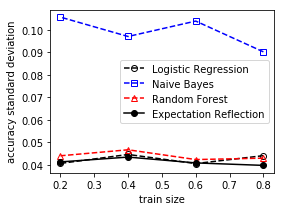

In [16]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,4],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()